In [2]:
import io
import itertools

import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [4]:
print(tf. __version__)

2.8.0


In [5]:
tf.__version__

'2.8.0'

In [6]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [7]:
mnist_dataset['train']

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
mnist_dataset['test']

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [10]:
mnist_train

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
mnist_test

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
def scale(image, label):
    
    image = tf.cast(image, tf.float32)
    image /= 255.
    
    return image, label

In [13]:
train_and_validation_data = mnist_train.map(scale)

test_data = mnist_test.map(scale)

In [14]:
train_and_validation_data

<MapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
test_data

<MapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
num_validation_samples = 0.1*mnist_info.splits['train'].num_examples

num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [17]:
num_test_samples = mnist_info.splits['test'].num_examples

num_test_samples = tf.cast(num_test_samples, tf.int64)

In [18]:
num_validation_samples

<tf.Tensor: shape=(), dtype=int64, numpy=6000>

In [19]:
num_test_samples

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

In [20]:
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [21]:
train_data = train_and_validation_data.skip(num_validation_samples)

validation_data = train_and_validation_data.take(num_validation_samples)

In [22]:
train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples)

test_data = test_data.batch(num_test_samples)

In [23]:
# Extracting the numpy arrays from the validation data for the calculation of the Confusion Matrix
for images, labels in validation_data:
    images_val = images.numpy()
    labels_val = labels.numpy()

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout

In [25]:
model = Sequential()

model.add(Conv2D(filters=50, kernel_size=5, activation='relu', input_shape=[28,28,1]))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=50, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(10))

In [26]:
model.summary(line_length=75)

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten (Flatten)               (None, 1250)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    12510

In [27]:
from tensorflow.keras.optimizers import Adam, SGD

In [28]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [29]:
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

In [30]:
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [31]:
log_dir = "Logs\\fit\\" + "run-1"


In [32]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [33]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [34]:
# Define a file writer variable for logging purposes
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(images_val)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
    
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [35]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=10, 
                           patience=6, 
                           restore_best_weights=True, 
                           mode='auto')

In [48]:
model.fit(train_data, 
          validation_data=validation_data, 
          epochs=NUM_EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1, 
          callbacks=[tensorboard_callback, cm_callback, early_stop])

Epoch 1/20
422/422 [==============================] - 37s 85ms/step - loss: 0.0112 - accuracy: 0.9965 - val_loss: 0.0070 - val_accuracy: 0.9982
Epoch 2/20
422/422 [==============================] - 36s 83ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0064 - val_accuracy: 0.9983
Epoch 3/20
422/422 [==============================] - 37s 85ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.0082 - val_accuracy: 0.9970
Epoch 4/20
422/422 [==============================] - 37s 85ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.0070 - val_accuracy: 0.9973
Epoch 5/20
422/422 [==============================] - 35s 81ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0078 - val_accuracy: 0.9980
Epoch 6/20
422/422 [==============================] - 36s 83ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.0090 - val_accuracy: 0.9963
Epoch 7/20
422/422 [==============================] - 37s 86ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.0045 - val_accuracy:

In [49]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 1s 1s/step - loss: 0.0312 - accuracy: 0.9913


In [50]:
print('Test loss: {:.4f}. Test accuracy: {:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0312. Test accuracy: 99.13%


In [52]:
%load_ext tensorboard
%tensorboard --logdir "logs/fit"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [44]:
import matplotlib.pyplot as plt
import numpy as np

In [84]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

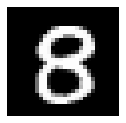

Label: 8


In [89]:
i = 7787


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

<BarContainer object of 10 artists>

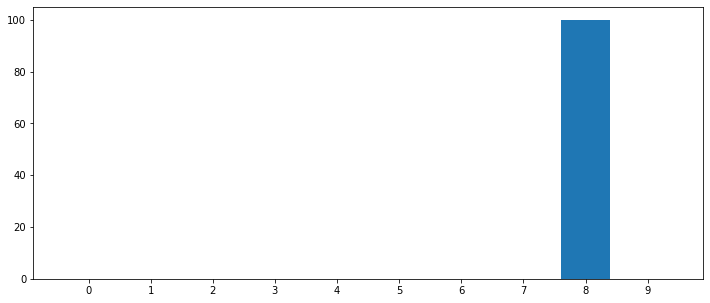

In [90]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])